# Roget's Thesaurus in the 21st Century

The first known thesaurus was written in the 1st century CE by [Philo of Byblos](https://en.wikipedia.org/wiki/Philo_of_Byblos); it was called *Περὶ τῶν διαφόρως σημαινομένων*, loosly translated in English as *On Synonyms*. Fast forward about two millenia and we arrive to the most well known thesaurus, compiled by [Peter Mark Roget](https://en.wikipedia.org/wiki/Peter_Mark_Roget), a British physician, natural theologian, and lexicographer. [Roget's Thesaurus](https://en.wikipedia.org/wiki/Roget%27s_Thesaurus) was released on 29 April 1852, containing 15,000 words. Subsequent editions were larger, with the latest totalling 443,000 words. In Greek the most well known thesaurus, *Αντιλεξικόν ή Ονομαστικόν της Νεοελληνικής Γλώσσης* was released in 1949 by [Θεολόγος Βοσταντζόγλου](https://el.wikipedia.org/wiki/%CE%98%CE%B5%CE%BF%CE%BB%CF%8C%CE%B3%CE%BF%CF%82_%CE%92%CE%BF%CF%83%CF%84%CE%B1%CE%BD%CF%84%CE%B6%CF%8C%CE%B3%CE%BB%CE%BF%CF%85); the latest updated edition was released in 2008 and remains an indispensable source for writing in Greek.

Roget organised the entries of the thesaurus in a hierarchy of categories.
The goal of this assignment is to investigate how these categories fare with the meaning of English words as captured by Machine Learning techniques, namely, their embeddings.

## Get Roget's Thesaurus Classification

Notebook is found here: [Roget's Thesaurus classification online at the Wikipedia](https://en.wiktionary.org/wiki/Appendix:Roget%27s_thesaurus_classification). 
The preprocessing is done seperately <a href="GetData.ipynb">here</a>

In [1]:
# Importing libraries and ignore warnings
import pandas as pd
import warnings

warnings.simplefilter("ignore")

## Get Word Embeddings

In pursuit of optimal embeddings for the project, a diverse array of models will be meticulously trialed and evaluated. While **Word2vec** serves as a cost-efficient option, its performance expectations remain modest. In contrast, the proprietary solutions such as **Gemini** and **OpenAI** present tantalizing prospects, albeit with associated expenses. Recognizing the unique demands of each API, embeddings will be generated through distinct Python scripts, ensuring tailored implementation for maximal efficiency and effectiveness in leveraging the varied model capabilities. This strategic approach harmonizes the quest for excellence with the practical considerations of resource allocation.

- The embeddings are already saved from multiple sources, but the python scripts that were used are in this folder, but an api key is needed to be added in order to execute:

In [2]:
#%run word2vec_embeddings.py # -->Rogets_Thesaurus_Embeddings.csv
#%run gemini_embeddings.py   # -->Rogets_Thesaurus_Embeddings(Gemini).csv
#%run openai_embeddings.py   # -->Rogets_Thesaurus_Embeddings(OpenAI).csv

<b>Note that the python scripts for gemini and openai also produce the embeddings for the centroids in the respective files</b>

## Clustering

With the embeddings at hand, you can check whether unsupervised Machine Learning methods can arrive at classifications that are comparable to the Roget's Thesaurus Classification. 

In [3]:
import tensorflow as tf
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
import numpy as np

2024-02-24 23:29:45.601663: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 23:29:45.603166: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 23:29:45.636350: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 23:29:45.636857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 23:29:46.187001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Lets create a method for clustering so we can try it with several different parameteres:

In [4]:
def perform_clustering(embedding_data, data, num_clusters=6, num_iterations=100, centroids=None):
    graph = tf.Graph()  # Create a new TensorFlow graph

    with graph.as_default():
        points = tf.constant(embedding_data.values, dtype=tf.float64)
        points_shape = points.shape.as_list()
        points_n = points_shape[0]
        embedding_dim = points_shape[1]

        if centroids is None:
            initial_centroids_idx = np.random.choice(points_n, num_clusters, replace=False)
            initial_centroids = tf.Variable(tf.gather(points, initial_centroids_idx))
        else:
            initial_centroids = tf.Variable(centroids)

        points_expanded = tf.expand_dims(points, 0)
        centroids_expanded = tf.expand_dims(initial_centroids, 1)

        distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
        assignments = tf.argmin(distances, 0)

        means = []
        for c in range(num_clusters):
            assigned_points = tf.boolean_mask(points, tf.equal(assignments, c))
            means.append(tf.reduce_mean(assigned_points, axis=0))

        new_centroids = tf.concat(means, 0)
        new_centroids_reshaped = tf.reshape(new_centroids, [num_clusters, embedding_dim])
        update_centroids = tf.compat.v1.assign(initial_centroids, new_centroids_reshaped)

        init = tf.compat.v1.global_variables_initializer()

    with tf.compat.v1.Session(graph=graph) as sess:
        sess.run(init)
        wcss_values = []  # List to store WCSS values for each iteration
        for _ in range(num_iterations):
            _, centroid_values, assignment_values, distances_eval = sess.run([update_centroids, initial_centroids, assignments, distances])
            wcss = np.sum(np.min(distances_eval, axis=0))
            wcss_values.append(wcss)

        # Create class cluster table
        data['Cluster'] = assignment_values
        class_cluster_table = data.groupby('Class')['Cluster'].value_counts().unstack(fill_value=0)

    # Print and display class cluster table
    print("Class Cluster Table:")
    display(class_cluster_table)

    # Plot the total within-cluster sum of squares (WCSS) over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_iterations + 1), wcss_values, marker='o', linestyle='-')
    plt.title('Total Within-Cluster Sum of Squares (WCSS) vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('WCSS')
    plt.grid(True)
    plt.show()

    # Calculate and print ARI and AMI
    ari = adjusted_rand_score(data['Class'], assignment_values)
    ami = adjusted_mutual_info_score(data['Class'], assignment_values)
    print(f"ARI: {ari}")
    print(f"AMI: {ami}")

    return assignment_values, class_cluster_table, centroid_values

Firstly, let's just use the embeddings, to see how close the classes our result will be:

2024-02-24 23:29:47.872044: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-24 23:29:47.875565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Class Cluster Table:


Cluster,0,1,2,3,4,5
Class,,,,,,
CLASS I,11,39,40,4,8,85
CLASS II,8,44,23,3,22,41
CLASS III,10,3,16,36,76,2
CLASS IV,46,11,66,10,12,14
CLASS V,67,32,119,3,3,5
CLASS VI,98,1,43,29,15,2


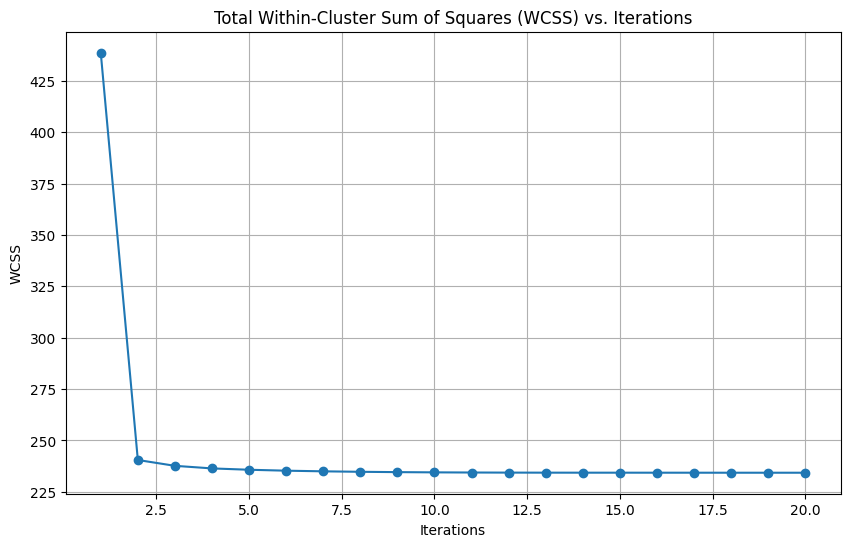

ARI: 0.14604363730669523
AMI: 0.2050983738800454


In [5]:
# Example usage:
data = pd.read_csv("Rogets_Thesaurus_Embeddings(Gemini).csv")
embedding_data = data.drop(['Class', 'Division', 'Section', 'Categories', 'Number', 'Words'], axis=1)

# Call the perform_clustering method
assignment_values, class_cluster_table, centroid_values = perform_clustering(embedding_data, data, num_iterations=20)

Let's now compare these centroids, with the centroids of the classes, as we have got them from gemini api:

In [6]:
# Load the embeddings DataFrame
data = pd.read_csv("Rogets_Thesaurus_Embeddings(Gemini).csv")

# Load the Class Centroids DataFrame
section_centroids = pd.read_csv("Class Centroids embed(Gemini).csv")

# Extract manual centroids from the Class Centroids DataFrame
manual_centroids = section_centroids.drop(['Class', 'Words'], axis=1).values

In [7]:
# Calculate Euclidean distance between each pair of points
distances = np.linalg.norm(centroid_values - manual_centroids, axis=1)

# Print the distances
print("Euclidean distances between corresponding centroids:")
for i, distance in enumerate(distances):
    print(f"Centroid {i+1}: {distance}")

Euclidean distances between corresponding centroids:
Centroid 1: 0.7035262036170581
Centroid 2: 0.6694867436922938
Centroid 3: 0.6770903372403367
Centroid 4: 0.6572302541325574
Centroid 5: 0.6763258857994248
Centroid 6: 0.6732108645370993


The distances are all arround 0.64, so let's plot them to have a better image:

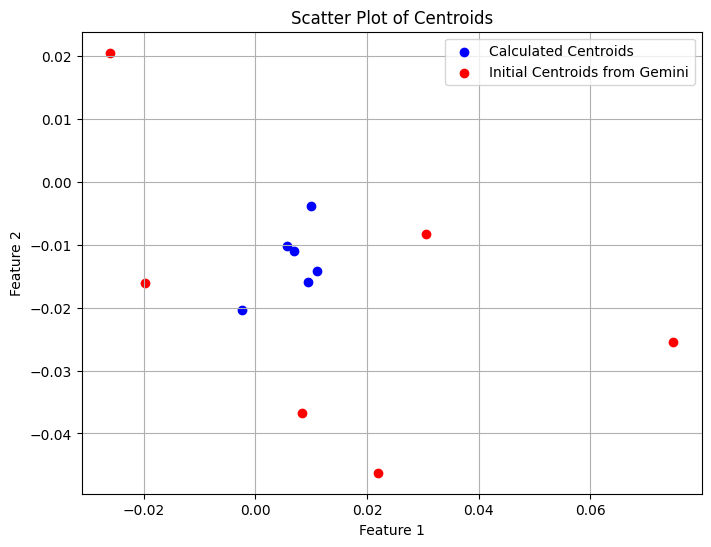

In [8]:
# Plot centroids
plt.figure(figsize=(8, 6))
plt.scatter(centroid_values[:, 0], centroid_values[:, 1], label='Calculated Centroids', color='blue')
plt.scatter(manual_centroids[:, 0], manual_centroids[:, 1], label='Initial Centroids from Gemini', color='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Centroids')
plt.legend()
plt.grid(True)
plt.show()

This shows that based on the algorithm used, the centroids created seem worse than the ones provided from Gemini and this shows the weakness of the clustering algorithm.

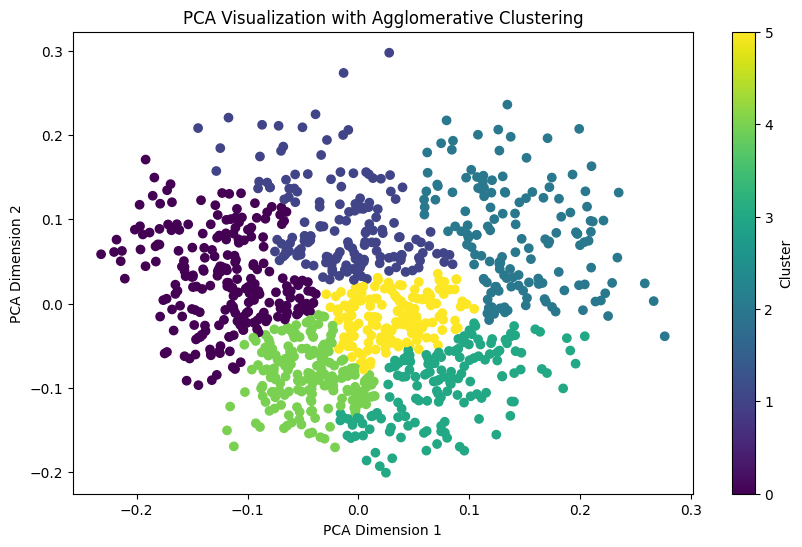

ARI: 0.12661428282456422
AMI: 0.1798092278504829


In [9]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

def perform_clustering_agglomerative(embedding_data, data):
    # Dimensionality Reduction using PCA
    pca = PCA(n_components=2, random_state=42)
    embedded_data = pca.fit_transform(embedding_data)

    # Clustering using Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=6)  # You can adjust the number of clusters
    assignments = agglomerative.fit_predict(embedded_data)

    # Create class cluster table
    data['Cluster'] = assignments
    class_cluster_table = data.groupby('Class')['Cluster'].value_counts().unstack(fill_value=0)

    # Plot clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=assignments, cmap='viridis')
    plt.title('PCA Visualization with Agglomerative Clustering')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.colorbar(label='Cluster')
    plt.show()

    # Calculate and print ARI and AMI (if ground truth available)
    ari = adjusted_rand_score(data['Class'], assignments)
    ami = adjusted_mutual_info_score(data['Class'], assignments)
    print(f"ARI: {ari}")
    print(f"AMI: {ami}")

    return assignments, class_cluster_table

# Call the function
assignment_values, class_cluster_table = perform_clustering_agglomerative(embedding_data.values, data)

While this clustering looks good, our metrics are worse than before, let's also try to categorise based on the hierarchical approach:

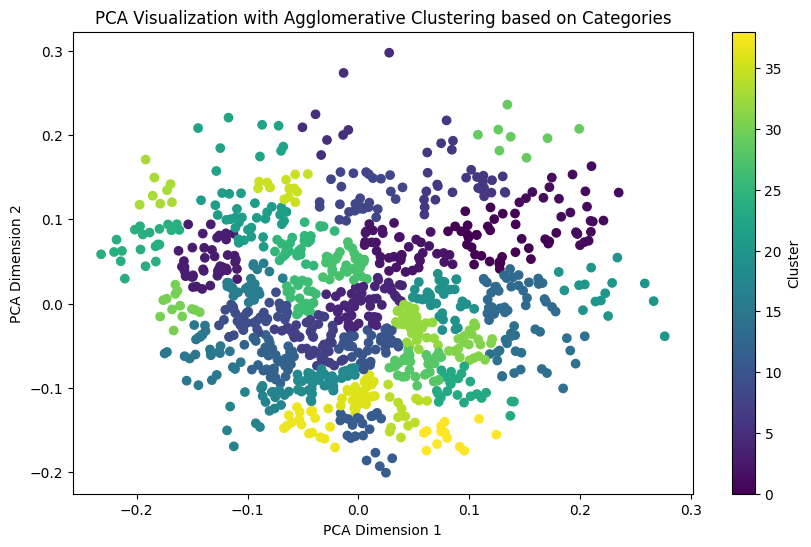

ARI: 0.0394593981650552
AMI: 0.13376840516756208


In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

def perform_clustering_agglomerative_categories(embedding_data, data):
    # Dimensionality Reduction using PCA
    pca = PCA(n_components=2, random_state=42)
    embedded_data = pca.fit_transform(embedding_data)

    # Clustering based on Categories using Agglomerative Clustering
    categories = data['Categories'].astype('category').cat.codes  # Convert categories to numerical codes
    agglomerative = AgglomerativeClustering(n_clusters=len(data['Categories'].unique()))  # Number of clusters based on unique categories
    assignments = agglomerative.fit_predict(embedded_data)

    # Create category cluster table
    data['Cluster'] = assignments
    category_cluster_table = data.groupby('Categories')['Cluster'].value_counts().unstack(fill_value=0)

    # Plot clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=assignments, cmap='viridis')
    plt.title('PCA Visualization with Agglomerative Clustering based on Categories')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.colorbar(label='Cluster')
    plt.show()

    # Calculate and print ARI and AMI (if ground truth available)
    ari = adjusted_rand_score(categories, assignments)
    ami = adjusted_mutual_info_score(categories, assignments)
    print(f"ARI: {ari}")
    print(f"AMI: {ami}")

    return assignments, category_cluster_table

# Call the function
assignment_values, category_cluster_table = perform_clustering_agglomerative_categories(embedding_data.values, data)


Still, the unsupervised algortihms don't seem to be able to really capture the categorization of the roget's thesaurus lexicon, so let's try some supervised approach:

## Class Prediction

Now we will try to come up with the best classification method, whose input will be a word and its target will be its class, or its section / devision.

In [11]:
# First import the needed libraries:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report

In [12]:
# Read the csv file with the words and embeddings
df = pd.read_csv("Rogets_Thesaurus_Embeddings(Gemini).csv")

# Define a function to remove dots, numbers, and spaces
def remove_chars(text):
    return ''.join(char for char in text if not char.isdigit() and char != '.')

# Apply the function
df['Number'] = df['Number'].apply(remove_chars).str.replace(' ', '')

df.head(5)

,Class,Division,Section,Categories,Number,Words,0,1,2,3,...,590,591,592,593,594,595,596,597,598,599
0,CLASS I,NaN,SECTION I,CLASS ISECTION I,Existence,"existence, entity, esse, subsistence, reality,...",-0.009984,-0.018131,-0.065819,-0.024999,...,-0.052980,0.014506,-0.035261,0.021034,-0.011823,0.002438,-0.018301,-0.028138,-0.017125,-0.021390
1,CLASS I,NaN,SECTION I,CLASS ISECTION I,Inexistence,"inexistence, nonexistence, nonsubsistence, non...",-0.005068,0.007970,-0.053576,-0.064443,...,-0.024073,-0.009667,-0.019435,-0.003696,0.005886,0.028090,0.014319,-0.060216,0.015825,0.009113
2,CLASS I,NaN,SECTION I,CLASS ISECTION I,Substantiality,"substantiality, hypostasis, person, thing, obj...",0.002696,-0.041860,-0.036634,-0.043128,...,-0.058428,0.012277,0.001373,0.002058,-0.015954,0.017719,0.005787,-0.050546,-0.023406,-0.012241
3,CLASS I,NaN,SECTION I,CLASS ISECTION I,Unsubstantiality,"unsubstantiality, insubstantiality, nothingnes...",-0.016329,-0.008885,-0.036515,-0.066743,...,-0.040770,0.007211,-0.017973,-0.012954,0.011620,0.033895,0.035679,-0.070624,-0.006228,-0.005525
4,CLASS I,NaN,SECTION I,CLASS ISECTION I,Intrinsicality,"intrinsicality, inbeing, inherence, inhesion, ...",-0.004389,-0.028964,-0.043431,-0.048232,...,-0.077312,0.014999,-0.025139,-0.025151,-0.018651,-0.005598,0.022620,-0.044678,-0.018402,-0.001000


In this dataset we have the 'Words' column that has all the words that describe each word.
<p> Let's try to use these words to classify the data:</p>

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def words_classifier(y):
    # Preprocessing
    df['Words'] = df['Words'].apply(lambda x: x.lower().split(', '))  # Split by comma and convert to lowercase
    
    # Convert the list of words into strings
    df['Words'] = df['Words'].apply(lambda x: ' '.join(x))
    
    # Feature extraction
    tfidf = TfidfVectorizer()
    X = tfidf.fit_transform(df['Words'])
    y = df['Class']
    
    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Model training
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Model evaluation
    print("Model Evaluation:")
    print(classification_report(y_test, y_pred))

In [14]:
words_classifier(df['Class'])

Accuracy: 0.680952380952381
Model Evaluation:
              precision    recall  f1-score   support

     CLASS I       0.71      0.72      0.72        40
    CLASS II       1.00      0.47      0.64        30
   CLASS III       0.95      0.62      0.75        34
    CLASS IV       0.85      0.63      0.72        35
     CLASS V       0.43      0.97      0.60        35
    CLASS VI       0.82      0.64      0.72        36

    accuracy                           0.68       210
   macro avg       0.79      0.67      0.69       210
weighted avg       0.79      0.68      0.69       210



The text classification model, implemented through the words_classifier function, achieved an overall accuracy of approximately 68.10% on the test data. Upon evaluation, it showed varying performance across different classes: while some classes such as CLASS III demonstrated high precision, recall, and F1-score, others like CLASS II exhibited a higher precision but lower recall, leading to a balanced F1-score. 
<p>Notably, CLASS V had a lower precision compared to recall, resulting in a comparatively lower F1-score. Remember that classes 4 and 5 are also splitter in divisions, so it expected that they will be a bit lower on precision and recall, on most of the models.

Now let's create a classification method, based on the embeddings of the words, and try it with different parameteres:

In [15]:
def train_and_evaluate_model(embeddings, class_labels, num_epochs=20):

    # Convert concatenated labels to numerical format
    label_encoder = LabelEncoder()
    encoded_classes = label_encoder.fit_transform(class_labels)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(embeddings, encoded_classes, test_size=0.2, random_state=42)

    # Define the neural network model
    model = Sequential()
    model.add(Dense(64, input_dim=embeddings.shape[1], activation='relu'))  # Input layer with 64 neurons and ReLU activation
    model.add(Dense(32, activation='relu'))  # Hidden layer with 32 neurons and ReLU activation
    model.add(Dense(len(np.unique(encoded_classes)), activation='softmax'))  # Output layer with softmax activation

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_split=0.2, verbose=0)

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Accuracy:", accuracy)

    # Additional evaluation metrics
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

Let's try this method, by using the embeddings of each word:

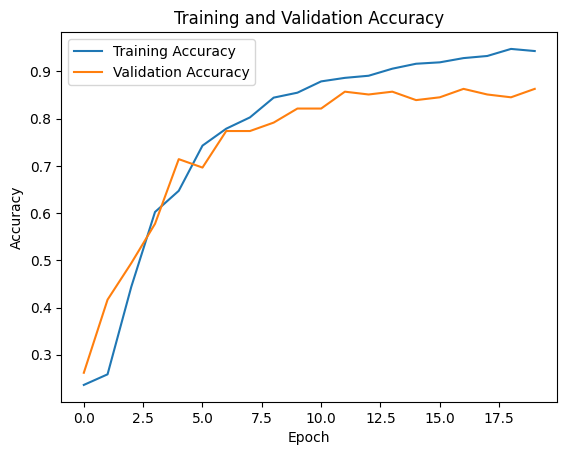

7/7 [==============================] - 0s 1ms/step - loss: 0.4775 - accuracy: 0.8381
Accuracy: 0.8380952477455139
7/7 [==============================] - 0s 970us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.85        40
           1       0.76      0.87      0.81        30
           2       0.93      0.76      0.84        34
           3       0.82      0.94      0.88        35
           4       0.78      0.89      0.83        35
           5       0.90      0.75      0.82        36

    accuracy                           0.84       210
   macro avg       0.84      0.84      0.84       210
weighted avg       0.85      0.84      0.84       210



In [16]:
train_and_evaluate_model(embeddings=df.iloc[:, 6:].values, class_labels=df['Class'])

Each iteration of the model execution yields a distinct model with varying levels of accuracy. 
<br>However, after ten attempts, the optimal performance was achieved with an accuracy of 84%. While this outcome demonstrates a commendable level of success, further enhancements could be explored by incorporating data from additional categories.
 <p><b>Let's try the hierarchical apporach:</b><a href="GetData.ipynb"> See how and why it was created</a></p>

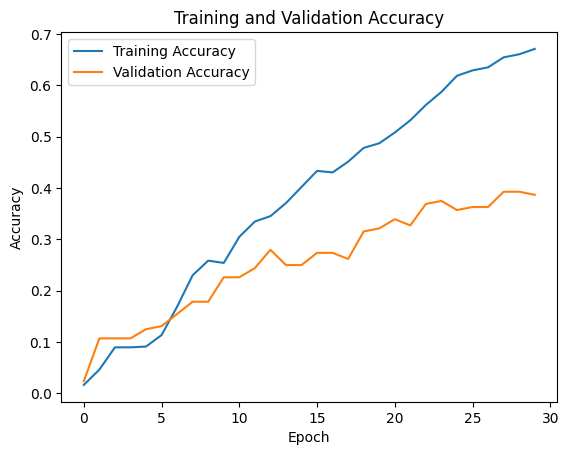

7/7 [==============================] - 0s 1ms/step - loss: 1.8086 - accuracy: 0.4619
Accuracy: 0.46190476417541504
7/7 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.62      0.67      0.64        12
           2       0.70      0.67      0.68        21
           3       0.00      0.00      0.00         3
           4       0.43      0.67      0.52         9
           5       0.20      0.25      0.22         4
           6       0.53      0.71      0.61        14
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4
           9       0.50      0.67      0.57         9
          10       0.00      0.00      0.00         9
          11       0.67      0.33      0.44         6
          12       0.57      0.80      0.67         5
          13       0.00      0.00      0.00         1

In [17]:
train_and_evaluate_model(embeddings=df.iloc[:, 6:].values, class_labels=df['Categories'],num_epochs=30)

Unfortunately this seems much worse, but it seems like it is still getting bettter after 20 epochs as the model gets more complicated when adding more variables.
<br> Even with the hierarchical approach, the accuracy is up to 64%. Of course, it will be harder to predict classes and divisions at the same time, so this is not the best approach, but also not terrible.
<br> Now we will try to predict the Categories, which remember is the two first levels of hierarchy combined:

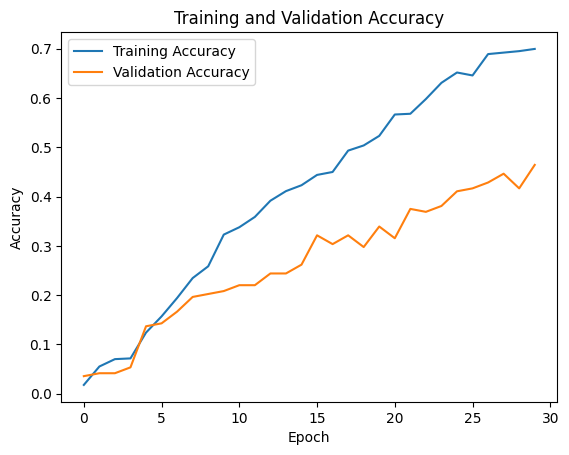

7/7 [==============================] - 0s 1ms/step - loss: 1.7030 - accuracy: 0.5238
Accuracy: 0.523809552192688
7/7 [==============================] - 0s 874us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.82      0.75      0.78        12
           2       0.76      0.76      0.76        21
           3       0.00      0.00      0.00         3
           4       0.56      1.00      0.72         9
           5       0.50      0.50      0.50         4
           6       0.67      0.86      0.75        14
           7       0.00      0.00      0.00         2
           8       0.33      0.25      0.29         4
           9       0.62      0.56      0.59         9
          10       0.67      0.22      0.33         9
          11       0.67      0.33      0.44         6
          12       0.40      0.80      0.53         5
          13       0.00      0.00      0.00         1

In [18]:
train_and_evaluate_model(embeddings=df.iloc[:, 6:].values, class_labels=df['Categories'],num_epochs=30)

### Let's now try to use another model with scikit learn

In [19]:
from sklearn.svm import SVC

In [20]:
def train_and_evaluate_model_sci(embeddings, class_labels, num_epochs=20):
    # Convert concatenated labels to numerical format
    label_encoder = LabelEncoder()
    encoded_classes = label_encoder.fit_transform(class_labels)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(embeddings, encoded_classes, test_size=0.2, random_state=42)

    # Define the SVM model
    svm_model = SVC(kernel='rbf', gamma='scale', C=1.0)

    # Train the model
    svm_model.fit(X_train, y_train)

    # Evaluate the model
    accuracy = svm_model.score(X_test, y_test)
    print("Accuracy:", accuracy)

    # Additional evaluation metrics
    y_pred = svm_model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

In [21]:
train_and_evaluate_model_sci(embeddings=df.iloc[:, 6:].values, class_labels=df['Class'])

Accuracy: 0.861904761904762
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.83      0.83      0.83        30
           2       0.97      0.85      0.91        34
           3       0.86      0.89      0.87        35
           4       0.76      0.91      0.83        35
           5       0.91      0.83      0.87        36

    accuracy                           0.86       210
   macro avg       0.87      0.86      0.86       210
weighted avg       0.87      0.86      0.86       210



This models seems slightly better, as the tensorflow models could not reach this accuracy. Let's test it with the OpenAI embeddings as well:

In [22]:
# Read the csv file with the words and embeddings
df = pd.read_csv("Rogets_Thesaurus_Embeddings(OpenAI).csv")

# Apply the function
df['Number'] = df['Number'].apply(remove_chars).str.replace(' ', '')

df.head(2)

,Class,Division,Section,Categories,Number,Words,0,1,2,3,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,CLASS I,NaN,SECTION I,CLASS ISECTION I,Existence,"existence, entity, esse, subsistence, reality,...",0.003961,0.019719,-0.010841,-0.002142,...,-0.000994,0.032939,0.017147,0.006741,0.000156,0.007384,0.001161,-0.000973,-0.024780,-0.000163
1,CLASS I,NaN,SECTION I,CLASS ISECTION I,Inexistence,"inexistence, nonexistence, nonsubsistence, non...",-0.019442,-0.001646,-0.013004,0.012372,...,0.006080,0.014566,0.018685,-0.005898,-0.014069,0.026181,-0.009074,-0.014676,-0.023624,-0.005377


In [23]:
train_and_evaluate_model_sci(embeddings=df.iloc[:, 6:].values, class_labels=df['Class'])

Accuracy: 0.9
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       0.85      0.93      0.89        30
           2       1.00      0.88      0.94        34
           3       0.94      0.94      0.94        35
           4       0.79      0.94      0.86        35
           5       0.94      0.81      0.87        36

    accuracy                           0.90       210
   macro avg       0.91      0.90      0.90       210
weighted avg       0.91      0.90      0.90       210



This seems like a much better result than the tensorflow before and it seems like the scikit learn is working better with the OpenAI embeddings
<p>This is the best result until now, so let's try this algorithm with the hierarchical apporach:</p>

In [24]:
train_and_evaluate_model_sci(embeddings=df.iloc[:, 6:].values, class_labels=df['Categories'])

Accuracy: 0.7428571428571429
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00        12
           2       0.64      1.00      0.78        21
           3       1.00      0.67      0.80         3
           4       0.64      1.00      0.78         9
           5       1.00      0.25      0.40         4
           6       0.76      0.93      0.84        14
           7       0.00      0.00      0.00         2
           8       0.60      0.75      0.67         4
           9       0.88      0.78      0.82         9
          10       0.67      0.22      0.33         9
          11       1.00      0.67      0.80         6
          12       0.67      0.80      0.73         5
          13       0.00      0.00      0.00         1
          14       1.00      0.75      0.86         4
          16       0.00      0.00      0.00         3
          17       0.00     

Certainly, the outcome is inferior compared to the scenario involving fewer classes, given the increased complexity of predicting 38 classes compared to 6. 
<p>Nonetheless, achieving a 74% accuracy rate is commendable, indicating the efficacy of contemporary machine learning methodologies in predicting word classifications established nearly two centuries ago. It is imperative, however, to acknowledge the possibility that the lexicon's word classifications may not always be optimal, potentially contributing to the 26% misclassification rate.</p>